# **Introduction**

This notebook is for implementing HPO using `Optuna` on the A2C implementation developed for `Cartpole`, both in the base and swingup versions. The hyperparameters that will be optimized are:

* The learning rate of the actor: $α_a$
* The learning rate of the critic: $α_c$
* The discount rate: γ
* The entropy scaling parameter: β
* The number of neurons per layer: $n_{neurons}$
* The number of layers: $n_{layers}$
* The number of steps to use in the return: $n_{steps}$

With the goal being to maximize the average return per episode while training the model over a set number of episodes, for a set number of trials.

# **Import Packages**

This section imports the necessary packages.

In [50]:
# import these packages:
import gymnasium as gym
from wrappers.swingup_wrapper import SwingUpWrapper
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import optuna
optuna.logging.set_verbosity(optuna.logging.ERROR)
import random
import datetime
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam

from collections import deque

# **Environment Setup**

This section sets up the environment and defines all relevant functions needed for this implementation.

##### Function for making Keras models:

In [51]:
# function for making a keras model:
def make_model(layers, neurons, rate, norm, drop, input_shape, output_shape, loss_function, output_activation):
    # instantiate model:
    model = keras.Sequential()

    # add hidden layers:
    for i in range(layers):
        if i == 0:
            model.add(Input(shape = (input_shape, )))
            model.add(Dense(neurons, activation = 'relu', name = f'hidden_layer_{i+1}'))
        else:
            model.add(Dense(neurons, activation = 'relu', name = f'hidden_layer_{i+1}'))

        if norm == True:
            model.add(BatchNormalization(name = f'batch_norm_layer_{i+1}'))

        if drop == True:
            model.add(Dropout(0.2, name = f'dropout_layer_{i+1}'))
    
    # add output layer:
    model.add(Dense(output_shape, activation = output_activation, name = 'output_layer'))

    # compile the model:
    model.compile(optimizer = Adam(learning_rate = rate),
                  loss = loss_function)
    
    return model 

##### A2C class:

In [52]:
# A2C class:
class A2C_Agent:
    ####################### INITIALIZATION #######################
    # constructor:
    def __init__(self,
                env: gym.Env,
                gamma: float, 
                lr_a: float, 
                lr_c: float,
                beta: float,
                layers = int,
                neurons = int,
                n_steps: int = 5):
        """ 
        this is the constructor for the agent. this agent uses the advantage actor-critic (A2C) algorithm to learn an optimal policy,
        through the use of two approximator networks. the first network, called the actor, is responsible for providing the probabilty 
        distribution over all actions given a state. the second network, called the critic, is responsible for utilizing the advantage function
        to guide the learning of the actor.

        env:                a gymnasium environment
        gamma:              a float value indicating the discount factor, γ
        lr_a:               a float value indicating the learning rate of the actor, α_a
        lr_c:               a float value indicating the learning rate of the critic, α_c
        beta:               a float value indicating the entropy regularization parameter, β
        layers:             an int value indicating the number of layers in a network
        neurons:            an int value indicating the number of neurons per layer
        n_steps:            an int value indicating the number of steps to use when computing the return

        nS:                 an int representing the number of states observed, each of which is continuous
        nA:                 an int representing the number of discrete actions that can be taken

        actor_network:      a Keras sequential neural network representing the actor
        critic_network:     a Keras sequential neural network representing the actor

        buf_states:         a list used to hold the states used in the n-step return
        buf_actions:        a list used to hold the actions used in the n-step return
        buf_rewards:        a list used to hold the rewards used in the n-step return
        buf_next_states:    a list used to hold the next states used in the n-step return
        buf_next_dones:     a list used to hold the dones used in the n-step return

        """
        # object parameters:
        self.env        = env
        self.gamma      = gamma
        self.lr_a       = lr_a
        self.lr_c       = lr_c
        self.beta       = beta
        self.n_steps    = n_steps

        # get the environment dimensions:
        self.nS = env.observation_space.shape[0]
        self.nA = env.action_space.n

        # initialize the networks:
        self.actor_network = make_model(layers = layers,
                                        neurons = neurons,
                                        rate = lr_a,
                                        norm = False,
                                        drop = False,
                                        input_shape = self.nS,
                                        output_shape = self.nA,
                                        loss_function = "categorical_crossentropy",
                                        output_activation = "softmax")
        
        self.critic_network = make_model(layers = layers,
                                        neurons = neurons,
                                        rate = lr_c,
                                        norm = False,
                                        drop = False,
                                        input_shape = self.nS,
                                        output_shape = 1,
                                        loss_function = "mse",
                                        output_activation = "linear")

        # create n-step buffers:
        self.buf_states         = []
        self.buf_actions        = []
        self.buf_rewards        = []
        self.buf_next_states    = []
        self.buf_dones          = []
    
    # function used to compute n-step returns, bootstrapping from the last value:
    def discount_rewards_from(self, last_value, rewards):
        r = np.zeros_like(rewards, dtype = np.float32)
        running = float(last_value)

        for t in reversed(range(len(rewards))):
            running = rewards[t] + self.gamma * running
            r[t] = running

        return r

    ####################### TRAINING #######################
    # decorated training step function:
    @tf.function
    def training_step(self, states, actions, returns):
        # convert values to tensors:
        states = tf.convert_to_tensor(states, dtype = tf.float32)       # shape is (B, nS)
        actions = tf.convert_to_tensor(actions, dtype = tf.int32)       # shape is (B, )
        returns = tf.convert_to_tensor(returns, dtype = tf.float32)     # shape is (B, )

        # CRITIC UPDATE:
        with tf.GradientTape() as critic_tape:
            # pass state through critic:
            values = tf.squeeze(self.critic_network(states, training = True), axis = 1)     # shape is (B, )

            # compute critic loss:
            critic_loss = tf.reduce_mean(tf.square(returns - values))

        # backpropagate and update critic:
        critic_grads = critic_tape.gradient(critic_loss, self.critic_network.trainable_variables)
        self.critic_network.optimizer.apply_gradients(zip(critic_grads, self.critic_network.trainable_variables))

        # ACTOR UPDATE:
        with tf.GradientTape() as actor_tape:
            # pass state through actor to get probs:
            probs = self.actor_network(states, training = True)             # shape is (B, nA)

            # take log of policy for scoring:   
            log_probs = tf.math.log(tf.clip_by_value(probs, 1e-8, 1.0))     # shape is (B, nA)

            # get a mask of the actions chosen:
            action_masks = tf.one_hot(actions, probs.shape[1], dtype = tf.float32)  # shape is (B, nA)

            # get log probs that were actually chosen:
            log_probs_chosen = tf.reduce_sum(action_masks * log_probs, axis = 1)    # shape is (B, )

            # entropy term:
            entropy_per_sample = -tf.reduce_sum(probs * log_probs, axis = 1)        # shape is (B, )

            # compute advantage:
            values_for_adv = tf.stop_gradient(tf.squeeze(self.critic_network(states, training = False), axis = 1))
            advantage = returns - values_for_adv        # shape is (B, )

            # normalize the advantage for stability:
            adv_mean, adv_var = tf.nn.moments(advantage, axes = [0])
            advantage_norm = (advantage - adv_mean) / (tf.sqrt(adv_var) + 1e-8)
            
            # compute actor loss, negative to maximize (ascent):
            actor_loss = -tf.reduce_mean(log_probs_chosen * advantage_norm) - self.beta * tf.reduce_mean(entropy_per_sample)

        # backpropagate and update actor:
        actor_grads = actor_tape.gradient(actor_loss, self.actor_network.trainable_variables)
        self.actor_network.optimizer.apply_gradients(zip(actor_grads, self.actor_network.trainable_variables))

    # gymnasium training function:
    def train(self, training_length, train_metrics, on_episode_end = None):
        # 1) initialize reward history:
        reward_history = []

        # for every episode:
        for episode in range(training_length):
            # 2) initialize per episode:
            obs, _ = self.env.reset()   # get initial state
            episode_reward = 0          # counter for reward earned this episode
            done = False                # flag for completion

            # clear buffers:
            self.buf_states.clear()
            self.buf_actions.clear()
            self.buf_rewards.clear()
            self.buf_next_states.clear()
            self.buf_dones.clear()

            # while not false:
            while not done:
                # 3) pick an action from the actor network output:
                obs_tensor = tf.convert_to_tensor(obs[None, :], dtype = tf.float32)
                probs = self.actor_network(obs_tensor, training = False)
                action = np.random.choice(len(probs[0]), p = probs.numpy()[0])

                # 4) step the environment:
                next_obs, reward, term, trunc, _ = self.env.step(action)
                episode_reward += reward
                done = bool(term or trunc)

                # 5) pass this transition to the buffers:
                self.buf_states.append(obs.copy())
                self.buf_actions.append(action)
                self.buf_rewards.append(reward)
                self.buf_next_states.append(next_obs.copy())
                self.buf_dones.append(done)

                # 6) training step if buffer is full:
                if len(self.buf_rewards) >= self.n_steps or done:
                    # if the last value is not terminal, bootstrap it:
                    if done: 
                        last_value = 0
                    else:
                        ns_tensor = tf.convert_to_tensor(self.buf_next_states[-1][None, :], dtype = tf.float32)
                        last_value = float(tf.squeeze(self.critic_network(ns_tensor, training = False)).numpy())
                    
                    # compute n-step returns with this last value:
                    returns = self.discount_rewards_from(last_value, self.buf_rewards)

                    # form batch arrays for states and actions corresponding to returns:
                    states_batch = np.vstack(self.buf_states).astype(np.float32)
                    actions_batch = np.array(self.buf_actions, dtype = np.int32)
                    returns_batch = returns.astype(np.float32)

                    # call the n-step training function:
                    self.training_step(states_batch, actions_batch, returns_batch)

                    # clear the buffers:
                    self.buf_states.clear()
                    self.buf_actions.clear()
                    self.buf_rewards.clear()
                    self.buf_next_states.clear()
                    self.buf_dones.clear()

                # 7) advance state:
                obs = next_obs
            
            # 8) advance reward history:
            reward_history.append(episode_reward)

            # 9) early stopping:
            if (episode + 1) >= train_metrics["min_train"]:
    
                recent_average = np.mean(reward_history[-train_metrics["over_last"]:]).round(3)

                if recent_average >= train_metrics["desired_score"]:
                    print(f"environment solved in {episode+ 1} episodes! average reward was: {recent_average}")
                    break

            # callback for pruning:
            if on_episode_end is not None:
                on_episode_end(episode, episode_reward)
            
        # 10) return to user:
        return reward_history, recent_average

##### Objective function for Optuna:

In [53]:
# define desired training performance for early stopping the training:
train_metrics = {"desired_score"    : 475,
                 "over_last"        : 100,
                 "min_train"        : 250}

# define an objective function that takes a trial object:
def objective(trial):
    # 0) initialization:
    # clear the backend:
    tf.keras.backend.clear_session()

    # define parameters for moving average used in pruning:
    window_size = 20
    recent_rewards = deque(maxlen = window_size)

    # define a callback that can be used every episode:
    def prune_callback(episode, episode_reward):
        # collect episode rewards into the deque:
        recent_rewards.append(episode_reward)

        # compute average reward:
        avg_reward = sum(recent_rewards) / len(recent_rewards)

        # prune report:
        trial.report(avg_reward, step = episode)
        if trial.should_prune():
            raise optuna.TrialPruned()

    # 1) create an environment:
    env = gym.make("CartPole-v1")

    # wrap environment:
    # env = SwingUpWrapper(env)

    # seeding:
    seed = 18
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    _, _ = env.reset(seed = seed)

    # 2) create an agent:
    agent = A2C_Agent(env = env,
                      lr_a = trial.suggest_categorical('lr_a', [1e-4, 2.5e-4, 5e-5, 1e-5, 2.5e-5, 5e-5]),
                      lr_c = trial.suggest_categorical('lr_c', [1e-2, 2.5e-2, 5e-2, 1e-3, 2.5e-3, 5e-3]),
                      gamma = trial.suggest_categorical('gamma', [0.95, 0.99, 0.995]),
                      beta = trial.suggest_categorical('beta', [0.1, 1e-2, 1e-3, 1e-4]),
                      layers = trial.suggest_categorical('layers', [2, 3]),
                      neurons = trial.suggest_categorical('neurons', [16, 24, 32, 64]),
                      n_steps = trial.suggest_int('n_steps', 2, 10)
                      )
    
    # 3) train the agent:
    reward_history, recent_average = agent.train(training_length = 1000, 
                                                 train_metrics = train_metrics, 
                                                 on_episode_end = prune_callback)

    # 4) close the environment:
    agent.env.close()

    # 6) save the recent average:
    trial.set_user_attr(f"last_{train_metrics['over_last']}", recent_average)

    # 7) return metric:
    return float(np.mean(reward_history).round(3))


# **Using the Environment**

This section performs the hyperparameter searching.

##### Query user about mode:

In [54]:
mode = input(f"Please select mode: Optimize or Analyze").lower()

if mode not in ["optimize", "analyze"]:
    raise SystemExit(f"Invalid mode selected.")

##### Create study and optimize:

In [55]:
if mode == "optimize":
    # get run time:
    time = datetime.datetime.now()
    formatted_time = time.strftime("%Y_%m_%d_%H_%M")

    # set study name:
    study_name = f"A2C_HPO_{formatted_time}"

    # create a study object and optimize the objective function:
    study = optuna.create_study(study_name = study_name,
                                direction = "maximize",
                                storage = "sqlite:///optuna_results.db",
                                load_if_exists = True,
                                pruner = optuna.pruners.MedianPruner(n_startup_trials = 5,
                                                                    n_warmup_steps = 0,
                                                                    interval_steps = 1))

    # optimize:
    study.optimize(objective, n_trials = 250)

##### Summarize results of study:

In [56]:
if mode == "analyze":
    # manually set the study to be analyzed:
    study_name = "A2C_HPO_2025_08_14_16_28"

    # load the study:
    study = optuna.load_study(study_name = study_name,
                              storage = "sqlite:///optuna_results.db")
    
    # get the best value:
    best_val = study.best_value
    tolerance = 10

    # find similar trials:
    similar_trials = [
        t for t in study.trials
        if t.state == optuna.trial.TrialState.COMPLETE and t.value is not None
        and abs(t.value - best_val) < tolerance
    ]
    
    # summarize study:
    trials_data = []
    intermediate_values = []
    for trial in similar_trials:

        # initialize dicts:
        trial_data = {}
        intermediate_value = {}

        # get trial information:
        trial_data["model"] = trial.number
        trial_data['value'] = trial.value
        trial_data[f"last_{train_metrics['over_last']}"] = trial.user_attrs[f"last_{train_metrics['over_last']}"]
        trial_data.update(trial.params.copy())
        trials_data.append(trial_data)

        # get intermediate values:
        intermediate_value.update(trial.intermediate_values.copy())
        intermediate_values.append(intermediate_value)

    # make data frame:
    summary = pd.DataFrame(trials_data)
    display(summary.head().sort_values(by = 'last_100', ascending = False))
else:
    pass

,model,value,last_100,lr_a,lr_c,gamma,beta,layers,neurons,n_steps
0,3,303.574,476.07,0.00005,0.001,0.99,0.1,2,64,2


##### Visualize results of study:

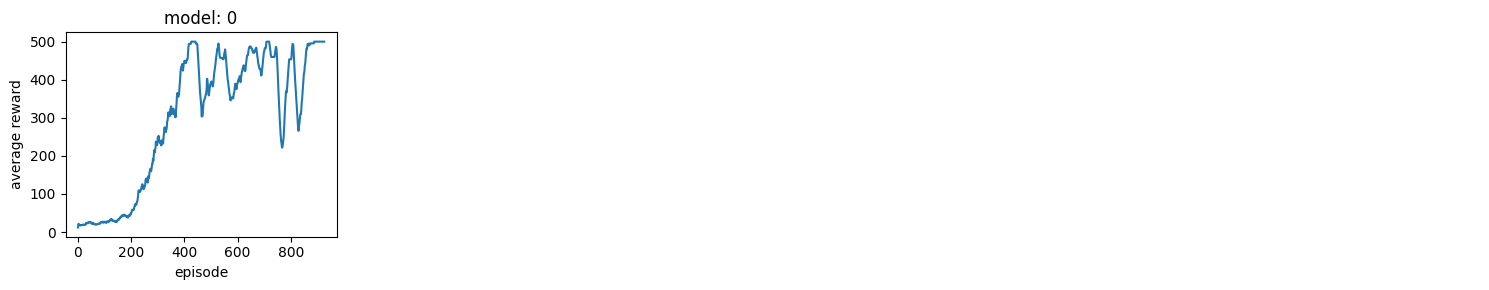

In [57]:
if mode == "analyze":
    # setup grid for subplots:
    n_plots = len(intermediate_values)
    cols = 5
    rows = (n_plots // cols) + (1 if n_plots % cols > 0 else 0) 

    # create the figure and axes:
    fig, axes = plt.subplots(rows, cols, figsize = (15, 3 * rows))
    axes = axes.flatten()

    # loop through trials and plot on each subplot:
    for i, trial in enumerate(intermediate_values):
        x = list(trial.keys())
        y = list(trial.values())

        ax = axes[i]
        ax.plot(x, y)
        ax.set_title(f"model: {i}")
        ax.set_xlabel("episode")
        ax.set_ylabel("average reward")

    # hide unused subplots (if there are any):
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    # adjust layout to prevent overlapping:
    plt.tight_layout()
    plt.show()
else:
    pass

##### Get params of best model:

In [59]:
if mode == "analyze":
    # visually, I determined that the best looking model was model:
    model_number = 0

    # get its values:
    display(summary.loc[model_number])
else:
    pass

model         3.00000
value       303.57400
last_100    476.07000
lr_a          0.00005
lr_c          0.00100
gamma         0.99000
beta          0.10000
layers        2.00000
neurons      64.00000
n_steps       2.00000
Name: 0, dtype: float64